In [19]:
# Cell 1 - Imports et paramètres globaux
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import skew
import scipy.cluster.hierarchy as sch
from ydata_profiling import ProfileReport
from sklearn.impute import SimpleImputer

sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# Réglages d'affichage
pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid")

##  1. Chargement des données

In [6]:
# Chargement des données traitées
train_df = pd.read_csv("../data/processed/train_merged.csv")
test_df  = pd.read_csv("../data/processed/test_merged.csv")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (307511, 135)
Test shape: (48744, 134)


## 2. Vue d'ensemble des données

In [7]:
#  Premier aperçu
train_df.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_count,credit_active_unique,total_credit_sum,prev_app_count,avg_amt_app,total_amt_credit,pos_cash_count,avg_months_balance,credit_card_count,avg_credit_balance,installments_count,total_amt_payment,avg_days_entry_payment
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,865055.565,1.0,179055.00,179055.0,19.0,-10.000000,NaN,NaN,19.0,219625.695,-315.421053
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,1017400.500,3.0,435436.50,1452573.0,28.0,-43.785714,NaN,NaN,25.0,1618864.650,-

In [8]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 135 entries, SK_ID_CURR to avg_days_entry_payment
dtypes: float64(78), int64(41), object(16)
memory usage: 316.7+ MB


In [9]:
train_df.describe().T.sort_values("std", ascending=False).style.background_gradient()


,count,mean,std,min,25%,50%,75%,max
total_credit_sum,263491.000000,1955806.586055,4101727.781706,0.000000,343377.270000,961704.000000,2297720.700000,1017957917.385000
total_amt_credit,291057.000000,953716.184620,1486623.060867,0.000000,157198.500000,427788.000000,1158408.000000,41461128.000000
total_amt_payment,291643.000000,678585.363490,916168.069643,0.000000,130826.992500,318619.485000,833093.932500,25537053.780000
AMT_CREDIT,307511.000000,599025.999706,402490.776996,45000.000000,270000.000000,513531.000000,808650.000000,4050000.000000
AMT_GOODS_PRICE,307233.000000,538396.207429,369446.460540,40500.000000,238500.000000,450000.000000,679500.000000,4050000.000000
AMT_INCOME_TOTAL,307511.000000,168797.919297,237123.146279,25650.000000,112500.000000,147150.000000,202500.000000,117000000.000000
avg_amt_app,291057.000000,154005.486423,153287.831054,0.000000,61925.737500,106002.000000,191250.000000,4050000.000000
DAYS_EMPLOYED,307511.000000,63815.045904,141275.766519,-17912.000000,-2760.000000,-1213.000000,-289.000000,365243.000000
avg_credit_balance,86905.000000,71459.926952,109056.518226,-2930.232558,0.000000,26793.606316,98610.502500,928686.323571
SK_ID_CURR,307511.000000,278180.518577,102790.175348,100002.000000,189145.500000,278202.000000,367142.500000,456255.000000


 ## 3. Statistiques de la variable cible

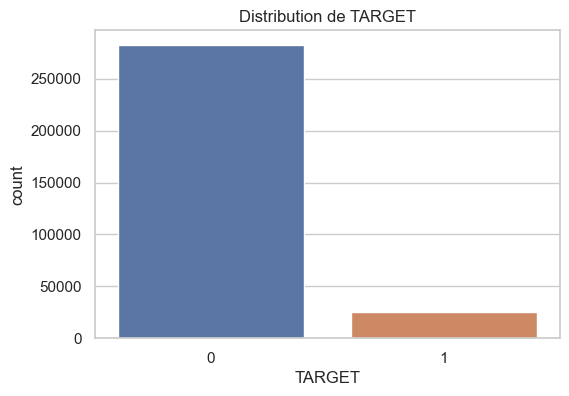

Ratio TARGET:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [11]:
#train_df["TARGET"].value_counts(normalize=True).plot(kind="bar", title="Distribution de la variable cible")
#  Distribution de la cible TARGET
plt.figure(figsize=(6,4))
sns.countplot(x="TARGET", data=train_df)
plt.title("Distribution de TARGET")
plt.show()

print("Ratio TARGET:")
print(train_df["TARGET"].value_counts(normalize=True))


## 4. Taux de valeurs manquantes

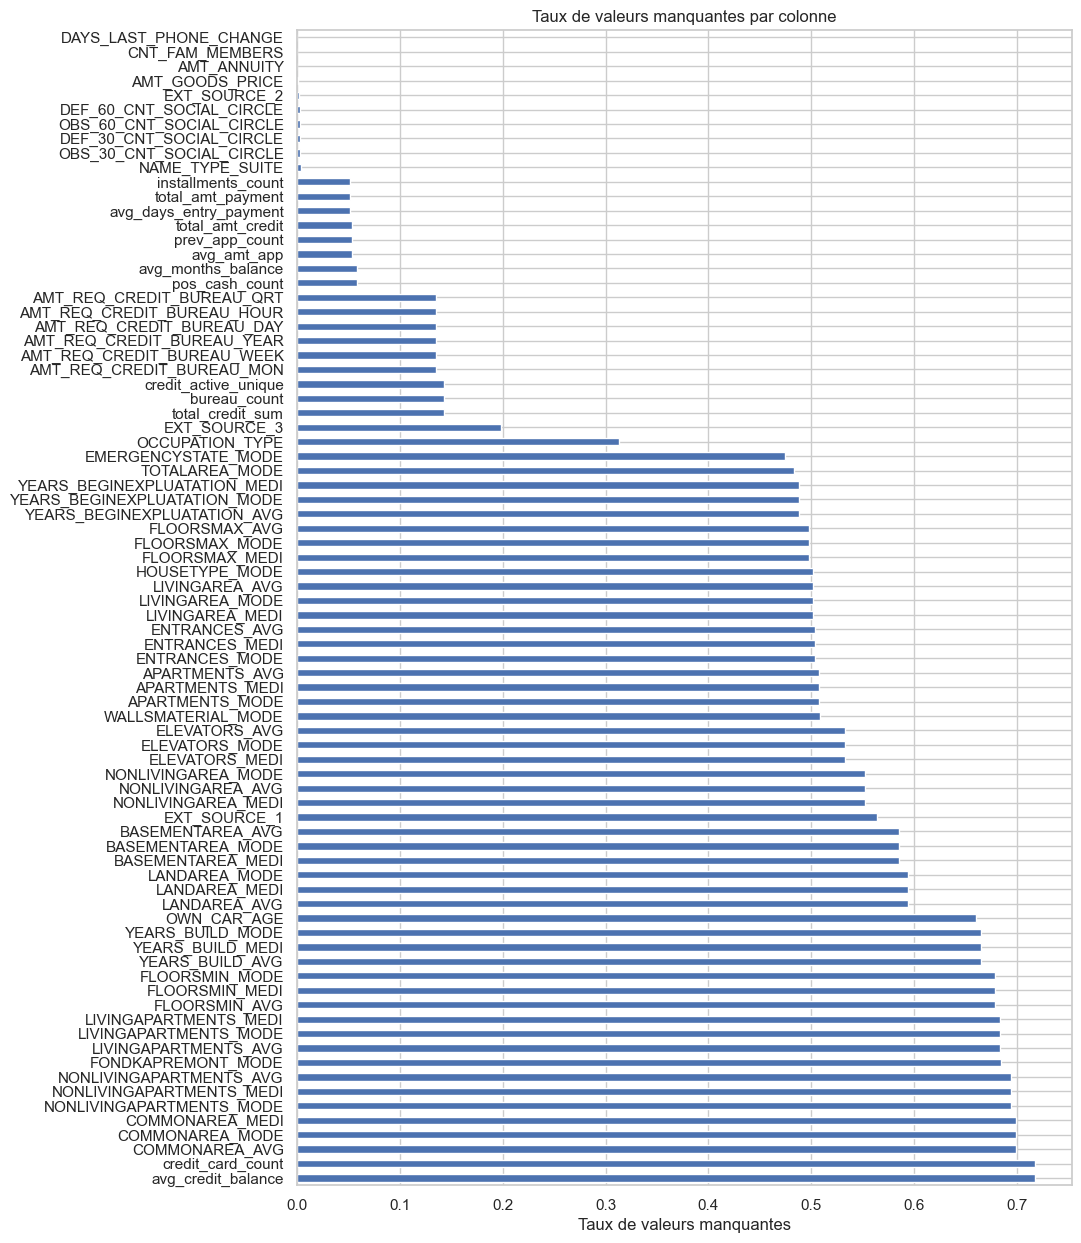

In [14]:
missing = train_df.isnull().mean().sort_values(ascending=False)
missing = missing[missing > 0]

plt.figure(figsize=(10, 15))
missing.plot(kind="barh")
plt.title("Taux de valeurs manquantes par colonne")
plt.xlabel("Taux de valeurs manquantes")
plt.show()


<Figure size 1200x600 with 0 Axes>

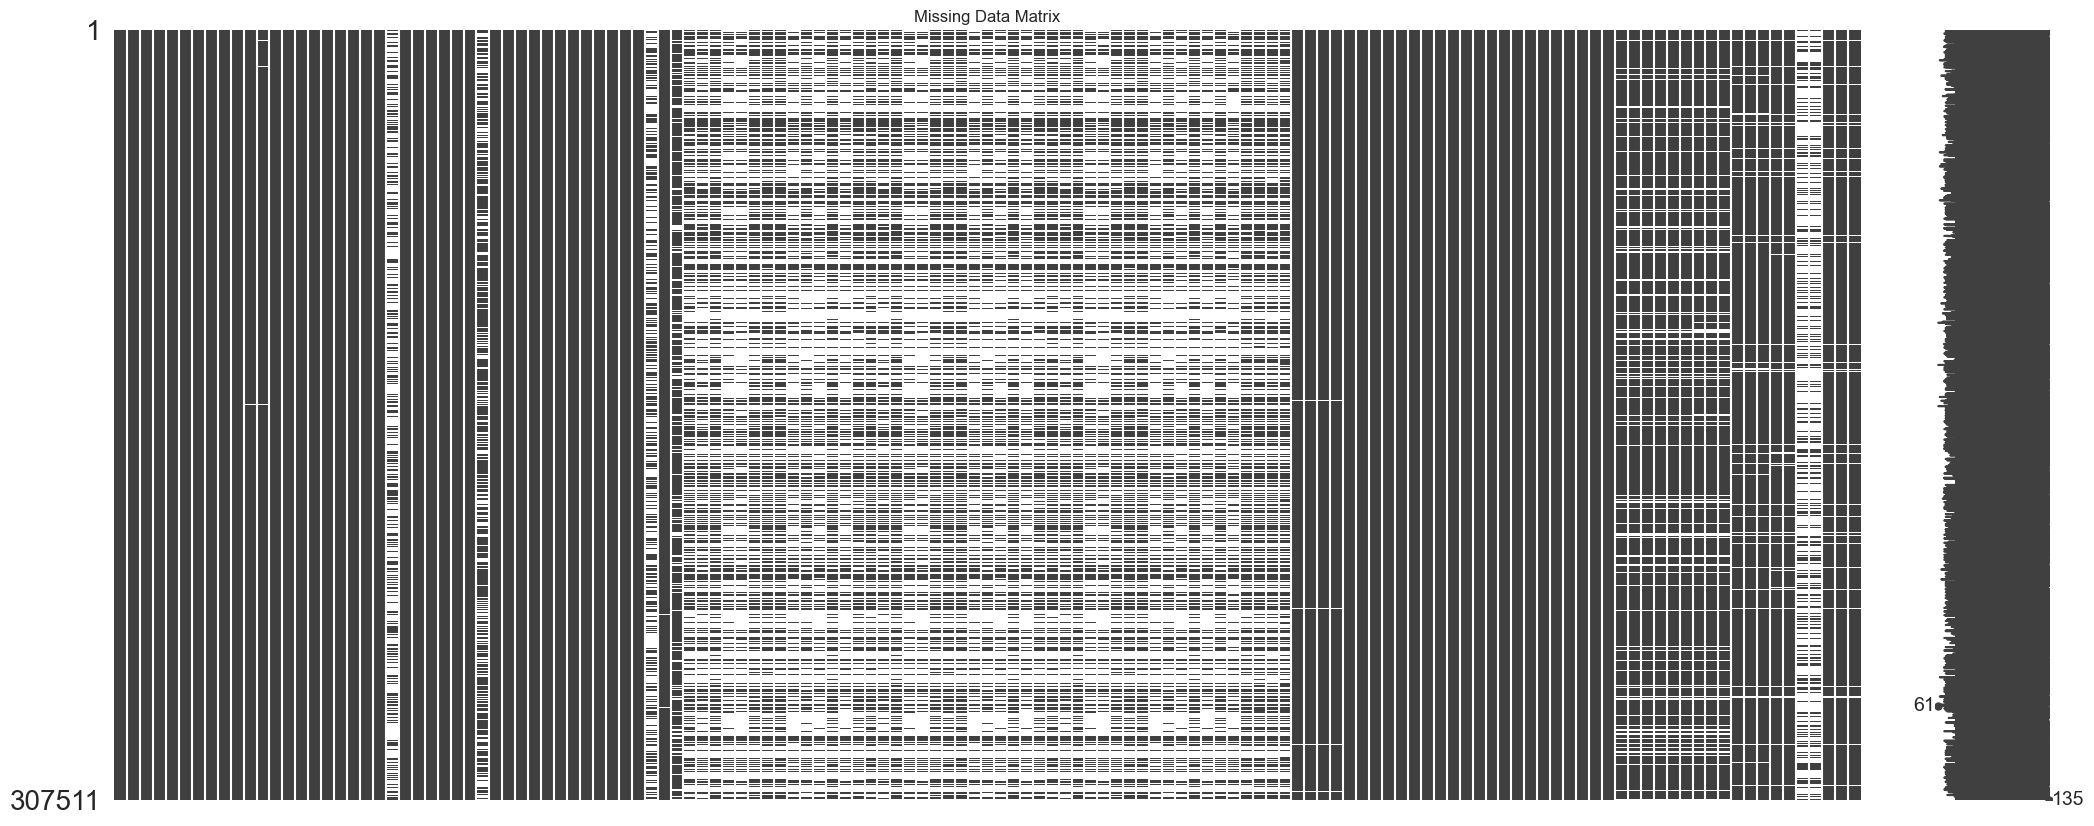

In [5]:
# Analyse des valeurs manquantes (missingno matrix)
plt.figure(figsize=(12, 6))
msno.matrix(train_df)
plt.title("Missing Data Matrix")
plt.show()


<Figure size 1500x600 with 0 Axes>

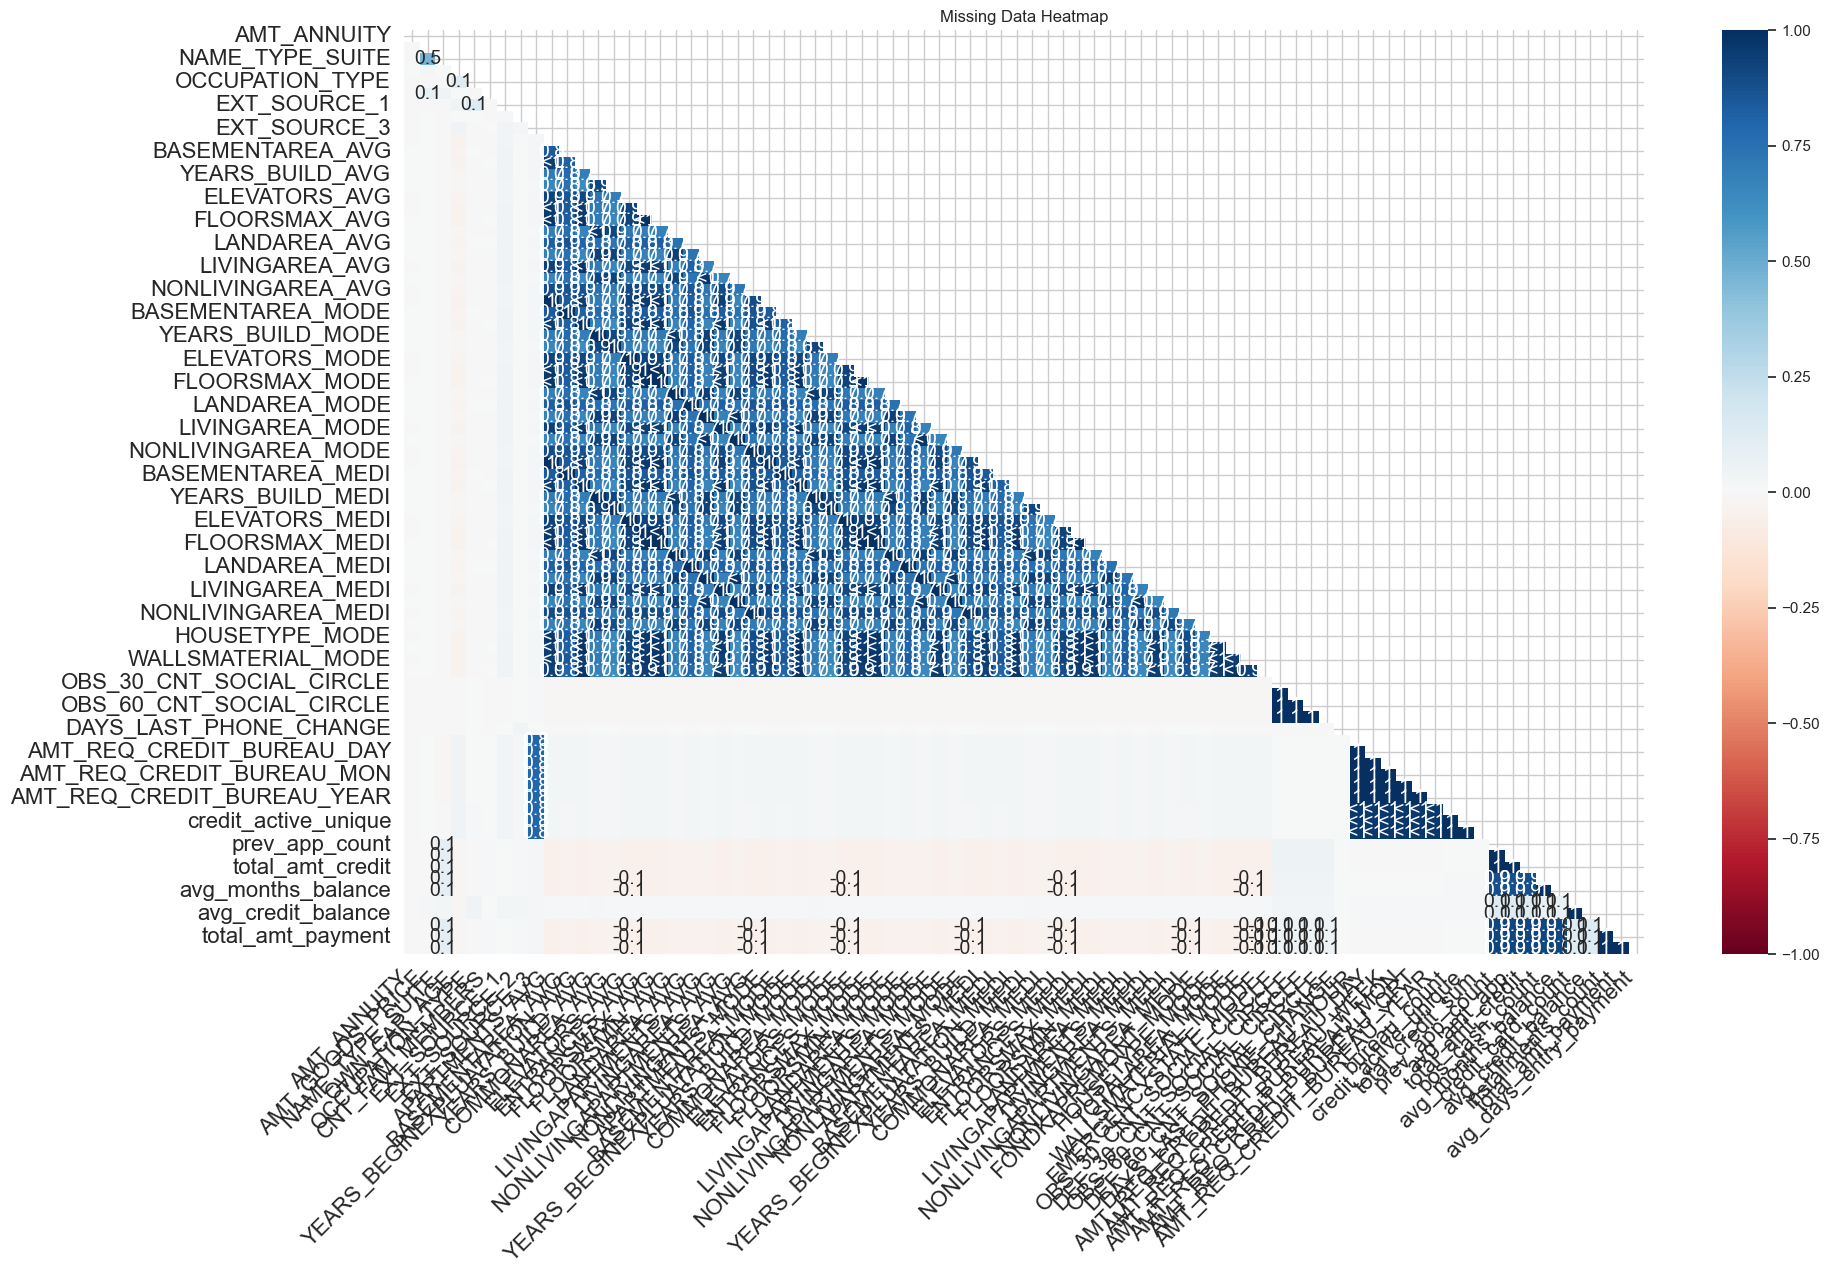

In [15]:
# Corrélations de missingness (missingno heatmap)
plt.figure(figsize=(15, 6))
msno.heatmap(train_df)
plt.title("Missing Data Heatmap")
plt.show()


 ## 5. Suppression de colonnes inutiles (trop de NaN ou constantes)


In [16]:
# Supprimer les colonnes avec + de 60% de NaN
threshold = 0.6
cols_to_drop_nan = missing[missing > threshold].index.tolist()

# Supprimer les colonnes constantes
nunique = train_df.nunique()
cols_constant = nunique[nunique <= 1].index.tolist()

cols_to_drop = cols_to_drop_nan + cols_constant
print(f"Colonnes supprimées: {cols_to_drop}")

train_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)


Colonnes supprimées: ['avg_credit_balance', 'credit_card_count', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'COMMONAREA_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE', 'OWN_CAR_AGE']


## 6. Séparer les variables numériques et catégorielles

In [21]:
TARGET = "TARGET"
num_cols = train_df.select_dtypes(include=["int64", "float64"]).columns.drop(TARGET)
cat_cols = train_df.select_dtypes(include=["object", "bool"]).columns
print(f"Numériques: {len(num_cols)}, Catégorielles: {len(cat_cols)}")


Numériques: 100, Catégorielles: 15


## 7. Imputation simple (valeurs manquantes)

In [22]:
# Imputation sur copie temporaire
train_df_clean = train_df.copy()
test_df_clean  = test_df.copy()

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

train_df_clean[num_cols] = num_imputer.fit_transform(train_df[num_cols])
train_df_clean[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])

test_df_clean[num_cols] = num_imputer.transform(test_df[num_cols])
test_df_clean[cat_cols] = cat_imputer.transform(test_df[cat_cols])


## 8. Corrélation avec la cible

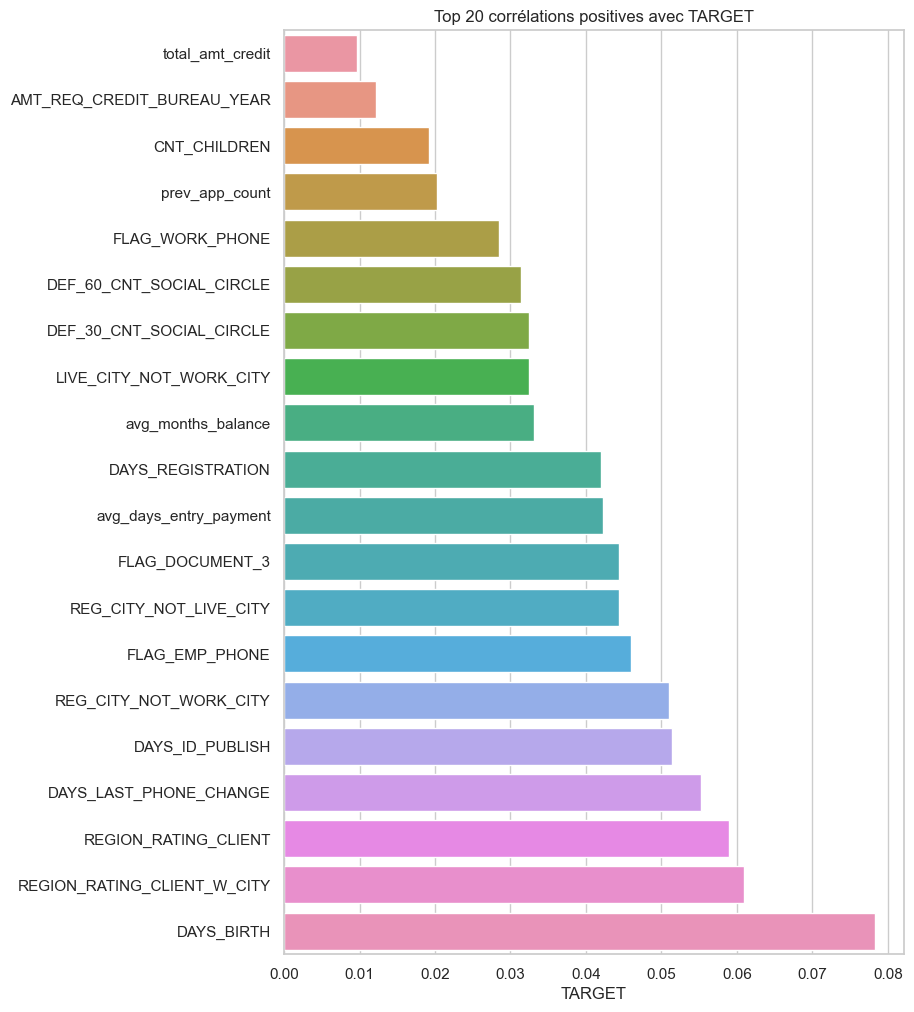

In [23]:
corrs = train_df_clean.corr(numeric_only=True)["TARGET"].drop("TARGET").sort_values()

plt.figure(figsize=(8, 12))
sns.barplot(x=corrs.tail(20), y=corrs.tail(20).index)
plt.title("Top 20 corrélations positives avec TARGET")
plt.show()


## 9. Export des données nettoyées

In [24]:
# Sauvegarde dans /data/interim/
train_df_clean.to_csv("../data/processed/train_clean.csv", index=False)
test_df_clean.to_csv("../data/processed/test_clean.csv", index=False)
print("Fichiers nettoyés sauvegardés.")


Fichiers nettoyés sauvegardés.


## 10. Analyse Univariée – Distributions des variables

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

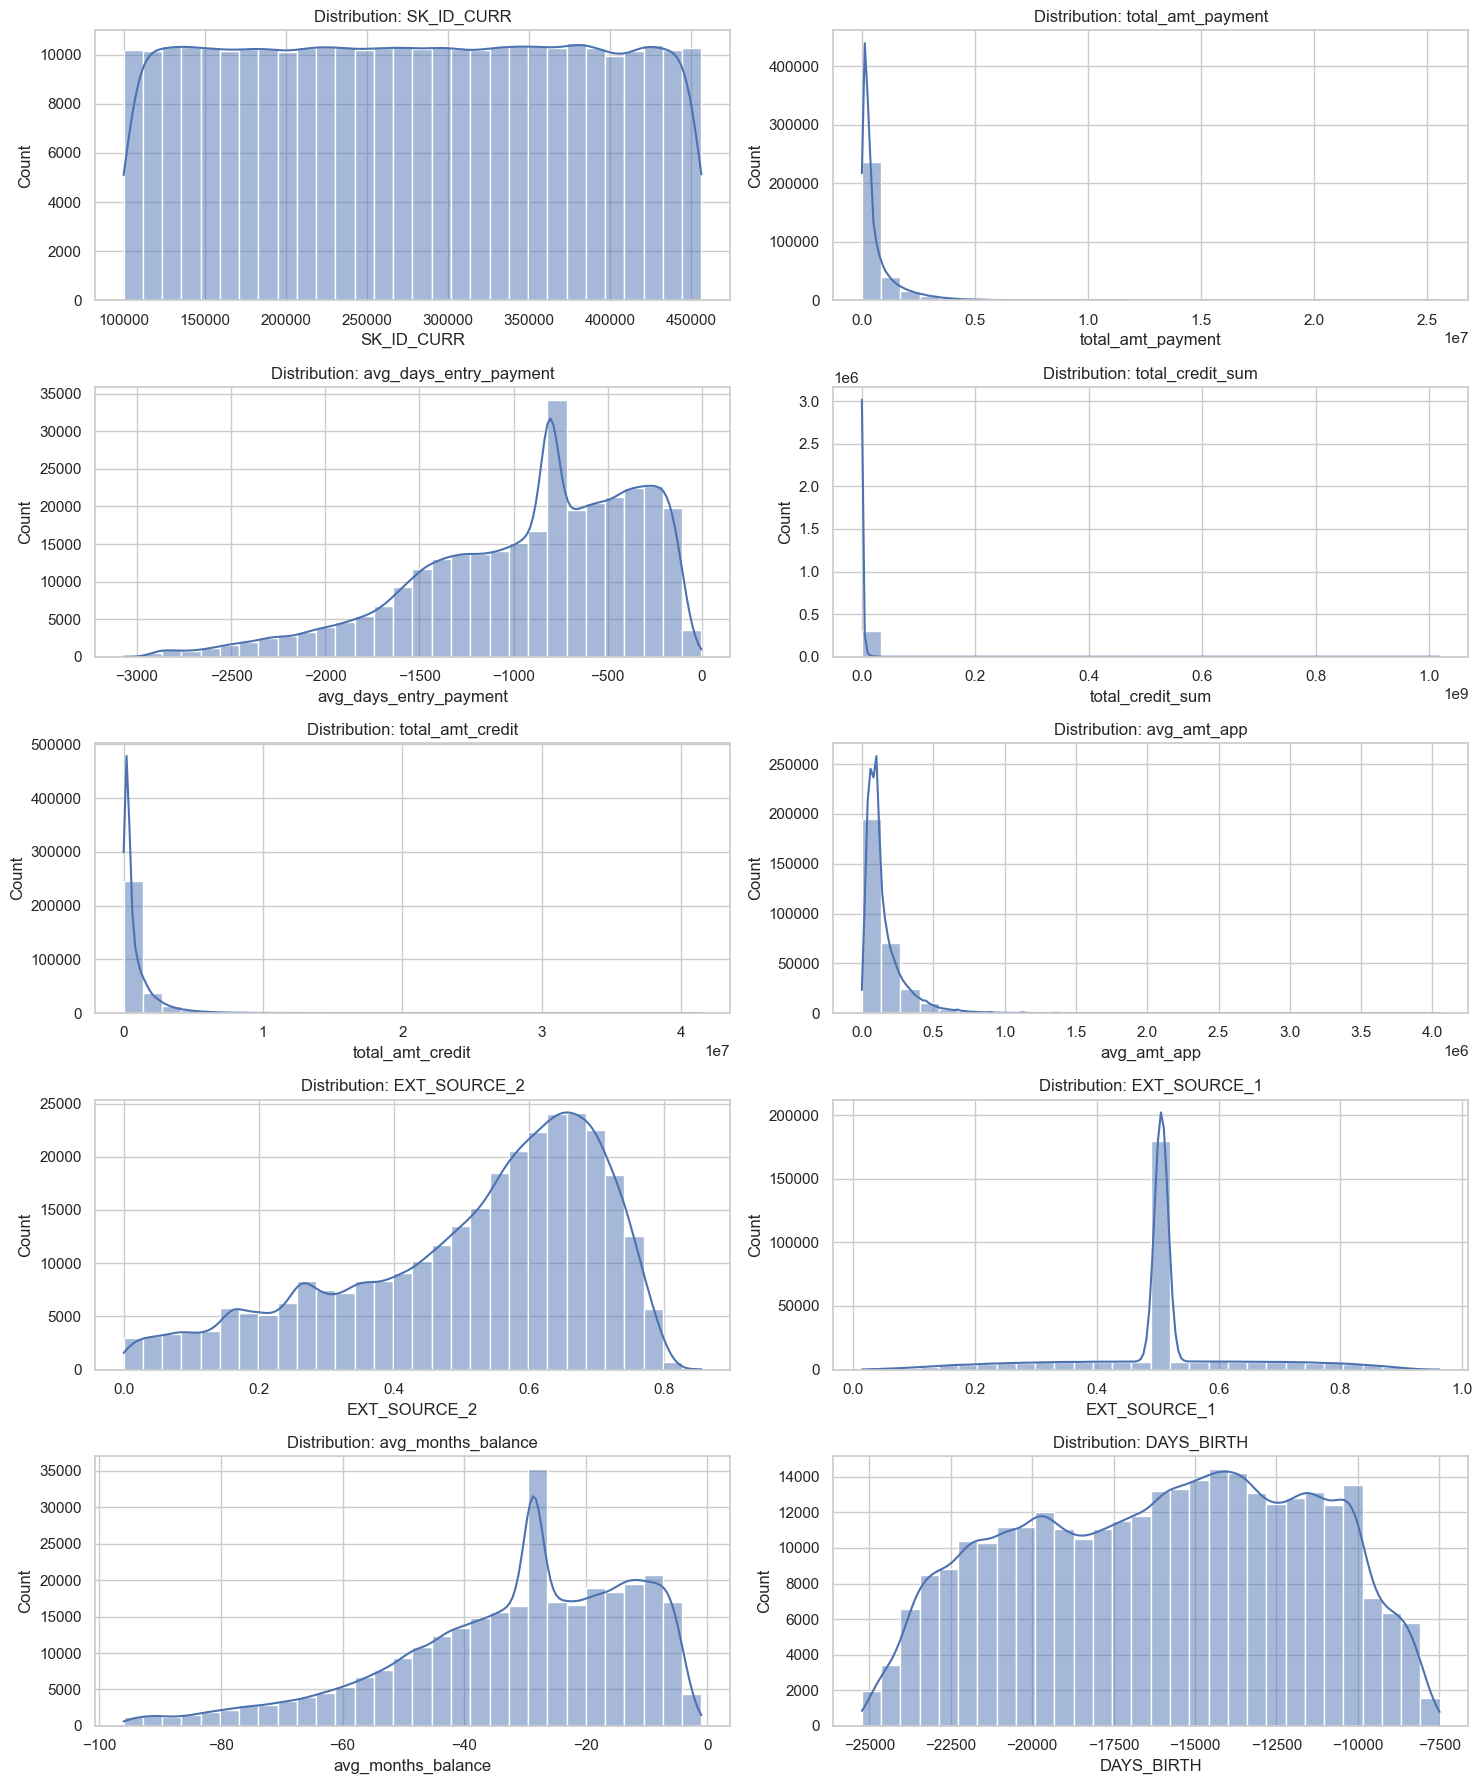

In [26]:
# Analyse univariée : distribution des principales variables numériques
top_num = train_df_clean[num_cols].nunique().sort_values(ascending=False).head(10).index.tolist()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))
axes = axes.flatten()

for idx, col in enumerate(top_num):
    sns.histplot(train_df_clean[col], kde=True, ax=axes[idx], bins=30)
    axes[idx].set_title(f"Distribution: {col}")

plt.tight_layout()
plt.show()


## 11. Analyse Bivariée – Variable cible vs numériques

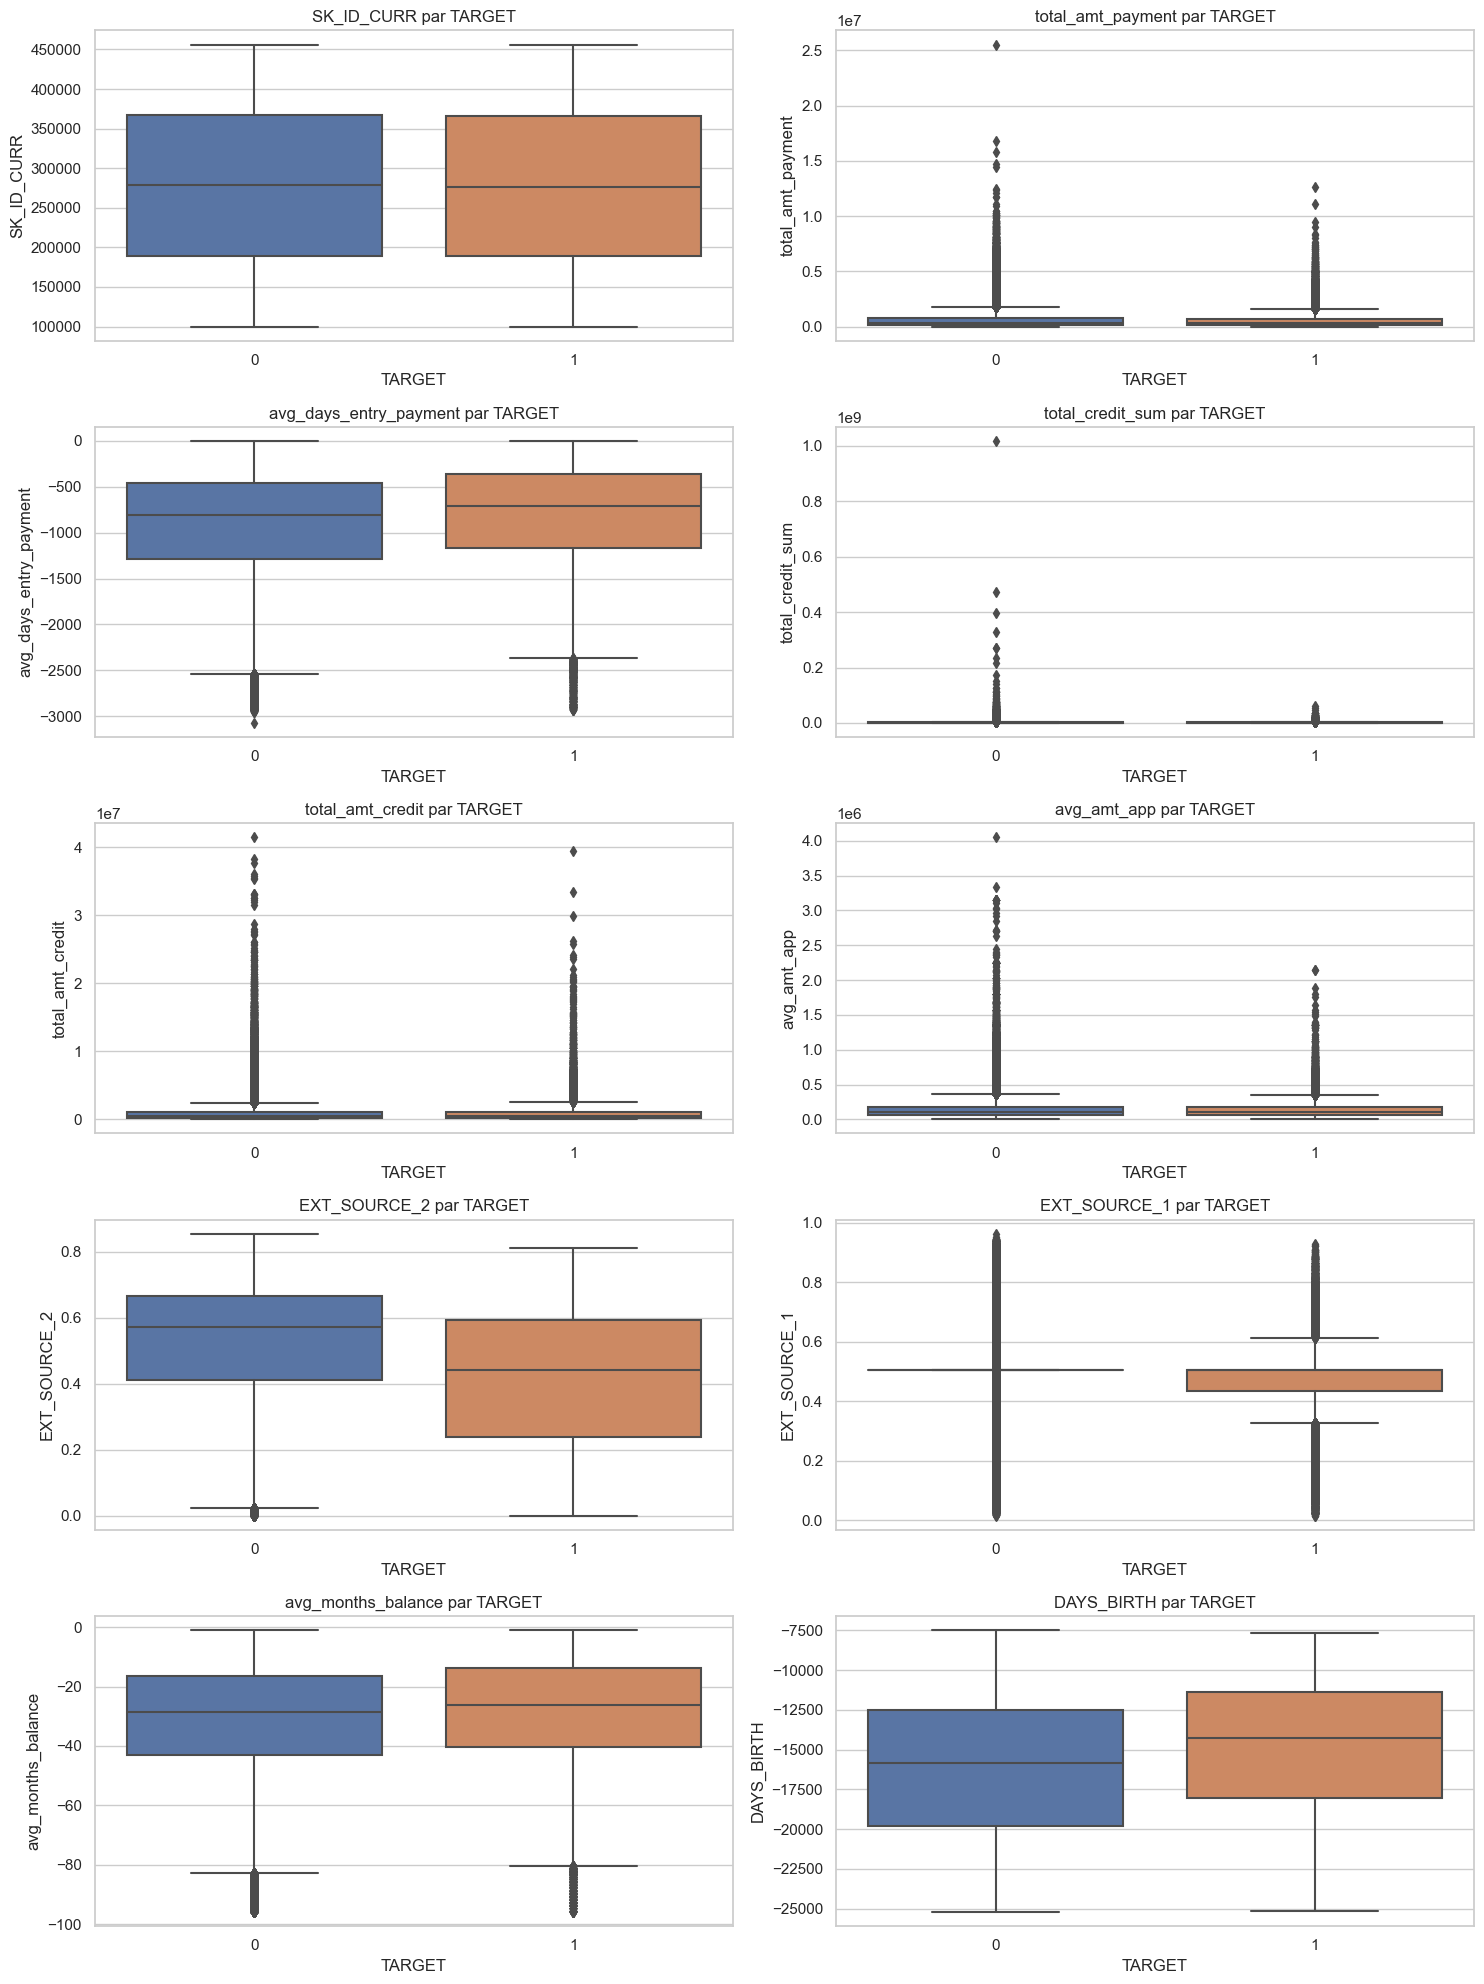

In [27]:

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for idx, col in enumerate(top_num):
    sns.boxplot(data=train_df_clean, x="TARGET", y=col, ax=axes[idx])
    axes[idx].set_title(f"{col} par TARGET")

plt.tight_layout()
plt.show()


## 12. Analyse Bivariée – Cible vs Catégorielles

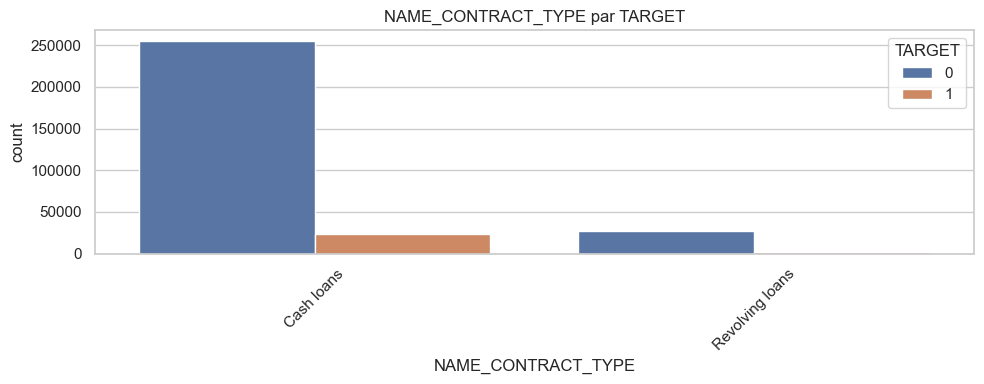

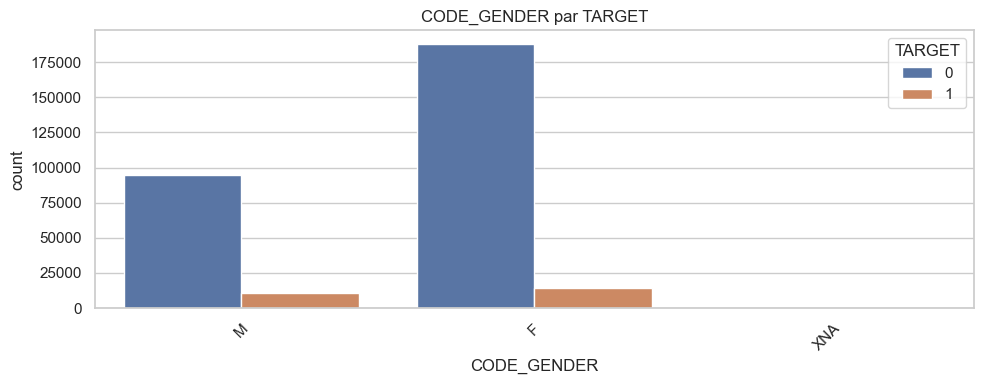

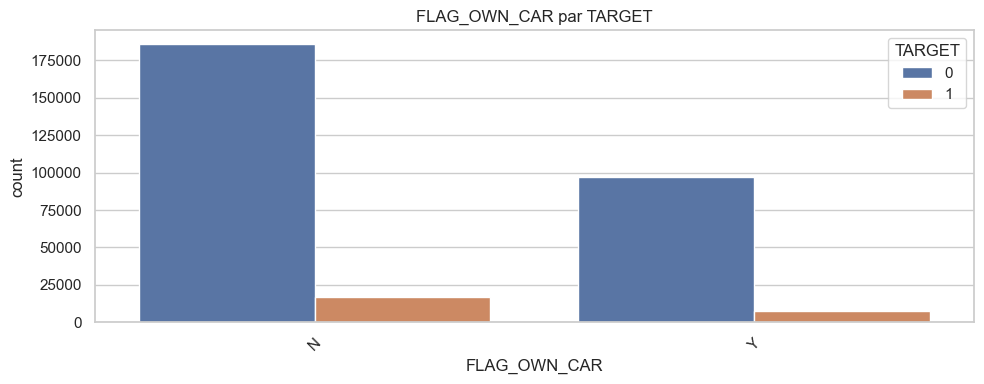

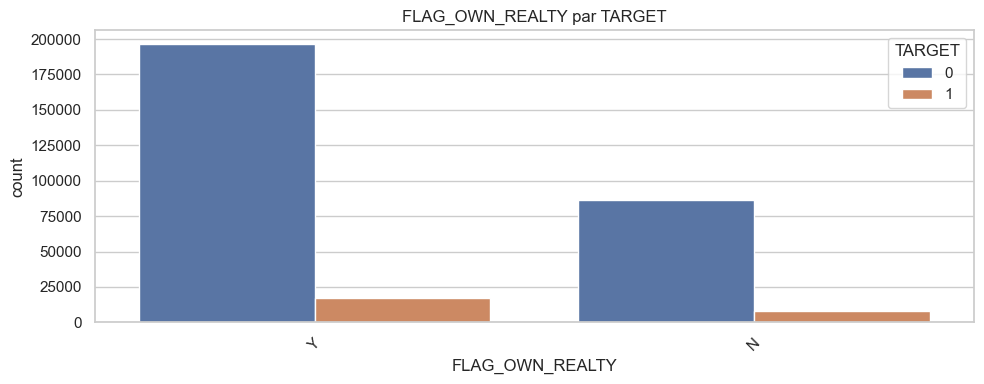

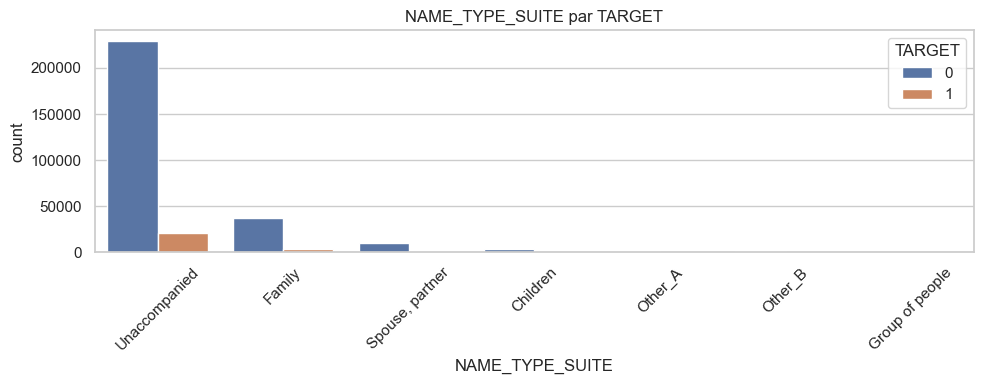

In [28]:
# variables catégorielles vs TARGET

for col in cat_cols[:5]:  # on limite à 5 pour la lisibilité
    plt.figure(figsize=(10, 4))
    sns.countplot(data=train_df_clean, x=col, hue="TARGET")
    plt.title(f"{col} par TARGET")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 13. Profiling interactif avec ydata-profiling

In [ ]:
# Rapport interactif avec ydata-profiling

from ydata_profiling import ProfileReport

profile = ProfileReport(train_df_clean, title="EDA – Profiling Interactif", explorative=True)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████| 116/116 [00:36<00:00,  3.22it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 14 Revenus par tranche d’âge et TARGET

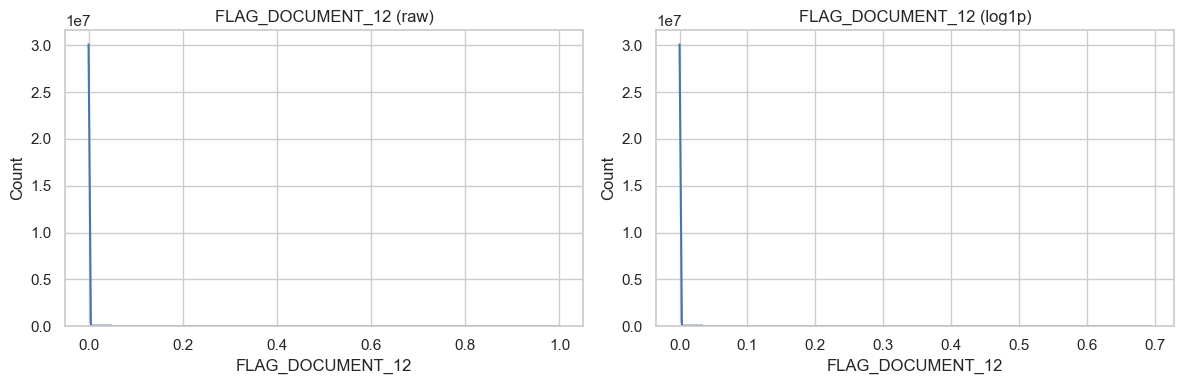

In [10]:
# 14. Analyse : AMT_INCOME_TOTAL par tranche d'âge et TARGET
# On crée une variable de tranche d'âge
train_df_clean["AGE_BIN"] = pd.cut(
    train_df_clean["DAYS_BIRTH"] / -365,
    bins=[20, 30, 40, 50, 60, 70],
    labels=["20-30", "30-40", "40-50", "50-60", "60-70"]
)

plt.figure(figsize=(10, 6))
sns.boxplot(x="AGE_BIN", y="AMT_INCOME_TOTAL", hue="TARGET", data=train_df_clean)
plt.title("Distribution des revenus par tranche d'âge et TARGET")
plt.ylabel("AMT_INCOME_TOTAL")
plt.tight_layout()
plt.show()



## 15. Pairplot sur un sous-ensemble de features


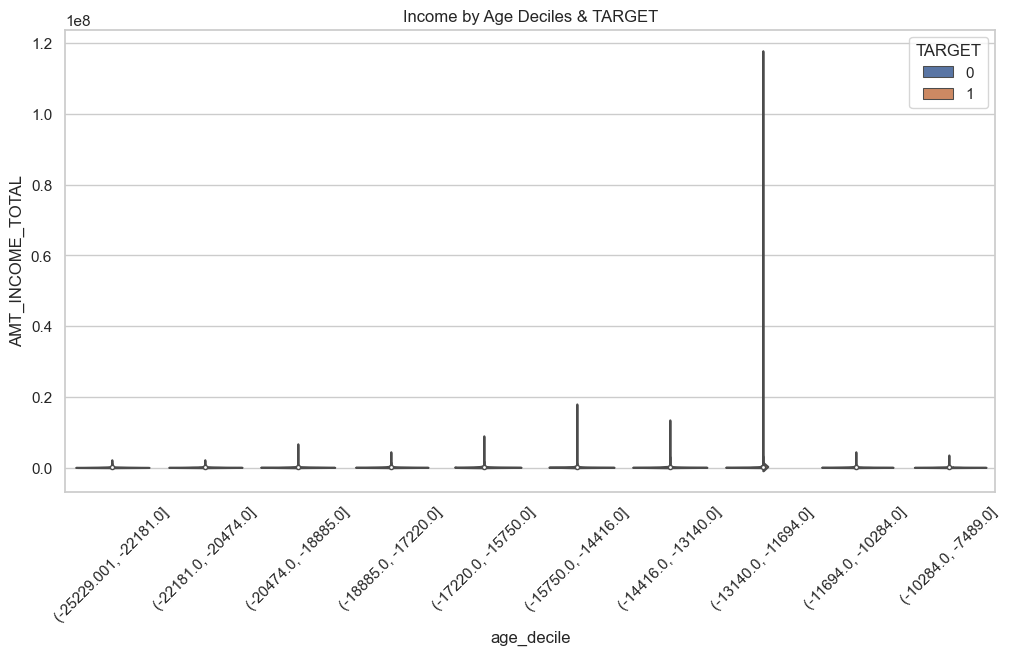

In [15]:
#  Pairplot : relations entre variables clés et TARGET
features_pairplot = [
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "TARGET"
]

# Échantillonnage pour lisibilité
sample_df = train_df_clean[features_pairplot].sample(1000, random_state=42)

sns.pairplot(sample_df, hue="TARGET", diag_kind="kde", palette="Set1")
plt.suptitle("Pairplot des variables financières et d'âge", y=1.02)
plt.show()



## 16. Heatmap de corrélation

In [ ]:
# 16. Heatmap de corrélation – variables clés
# Corrélation sur variables numériques uniquement
corrmat = train_df_clean[num_cols].corr()

# Sélection des 15 plus corrélées avec TARGET
top_corr_features = corrmat["TARGET"].abs().sort_values(ascending=False).head(15).index
plt.figure(figsize=(12, 10))
sns.heatmap(train_df_clean[top_corr_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap des 15 variables les plus corrélées à TARGET")
plt.tight_layout()
plt.show()


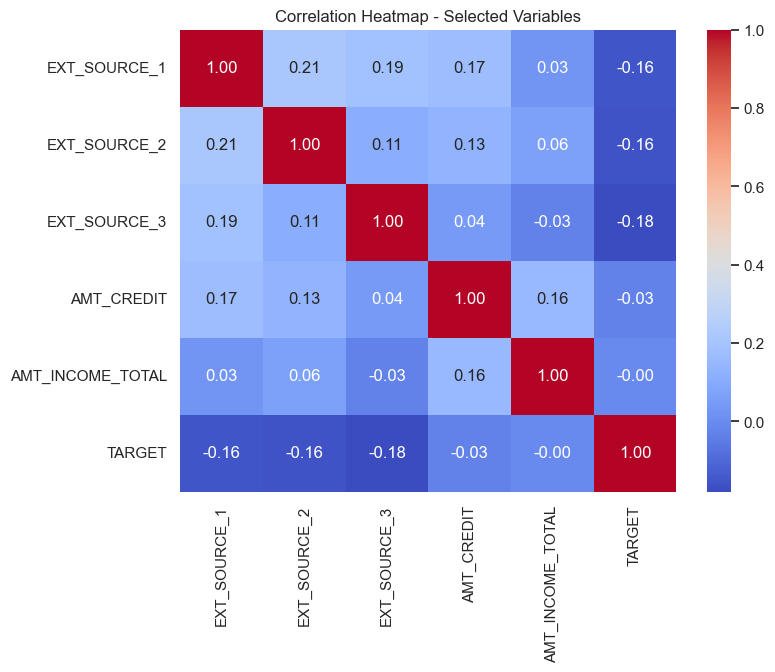

In [17]:
# Heatmap de corrélation sur variables clés
key_vars = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "AMT_CREDIT", "AMT_INCOME_TOTAL", "TARGET"]
plt.figure(figsize=(8,6))
sns.heatmap(train_df[key_vars].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap - Selected Variables")
plt.show()


In [1]:
import shap
print(shap.__version__)


0.46.0


In [36]:
pip install shap==0.46.0 --upgrade

  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.3/459.3 kB 252.8 kB/s eta 0:00:0000:0100:01
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.7
    Uninstalling slicer-0.0.7:
      Successfully uninstalled slicer-0.0.7
  Attempting uninstall: shap
    Found existing installation: shap 0.41.0
    Uninstalling shap-0.41.0:
      Successfully uninstalled shap-0.41.0
Note: you may need to restart the kernel to use updated packages.
